### Import libraries and other helper classes

In [1]:
# !pip install rsome
# !pip install gurobipy
# !pip install openpyxl
# !pip install matplotlib
# !pip install seaborn
# !pip install sklearn
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from rsome import ro
from rsome import grb_solver as grb

In [2]:
from enum import Enum

class TRANSPORT_MODE(Enum):
    TRUCK = "Truck"
    RAIL = "Rail"
    AIR = "Air"

In [3]:
from enum import Enum

class SCTG_CATEGORIES(Enum):
    URGENT = "Perishable products and Pharmaceutical items"
    PRIORITY = "Machinery and Energy-related items"
    OTHERS = "Other Items"

### Import the main dataset

In [4]:
# from google.colab \
# import drive
# import os, glob
#
# my_name = 'proje.ipynb'
#
# drive.mount(os.getcwd() + '/drive', force_remount=True)
# my_path = glob.glob(os.getcwd() + '/**/' +
# my_name, recursive = True)
#
# my_path = [my_i
#            for my_i in my_path if len(my_i) in [max([len(my_i)
#            for my_i in my_path])]
#           ][0]
#
# my_path = my_path.split('/')[:-1]
#
# my_dir = ''
# for i in my_path:
#   my_dir += i + '/'
# print(my_dir)
my_dir = ''

In [5]:
df_full = pd.read_csv(my_dir+"cfs_2012_pumf_csv.csv")
df_full.head()

,SHIPMT_ID,ORIG_STATE,ORIG_MA,ORIG_CFS_AREA,DEST_STATE,DEST_MA,DEST_CFS_AREA,NAICS,QUARTER,SCTG,MODE,SHIPMT_VALUE,SHIPMT_WGHT,SHIPMT_DIST_GC,SHIPMT_DIST_ROUTED,TEMP_CNTL_YN,EXPORT_YN,EXPORT_CNTRY,HAZMAT,WGT_FACTOR
0,1,25,148,25-148,25,148,25-148,333,2,35,14,2178,11,14,17,N,N,N,N,208.5
1,2,42,428,42-428,6,41740,06-41740,311,3,35,14,344,11,2344,2734,N,N,N,N,193.3
2,3,26,220,26-220,47,314,47-314,322,2,27,4,4197,5134,470,579,N,N,N,N,51.2
3,4,20,556,20-556,20,556,20-556,323,1,29,4,116,6,3,3,N,N,N,N,238.7
4,5,12,99999,12-99999,12,99999,12-99999,4235,3,33,5,388,527,124,201,N,N,N,N,398.1


### Import the data on transport mode and map

In [6]:
transport_mode = pd.read_excel(my_dir+'cfs-2012-pum-file-users-guide-app-a-jun2015.xlsx', sheet_name='App A4', header=1).iloc[:, :2]
last_row_with_nan = transport_mode.isna().all(axis=1).to_numpy().nonzero()[0][-1]-2
transport_mode = transport_mode.iloc[:last_row_with_nan, :]
transport_mode['Mode Code'] = transport_mode['Mode Code'].astype(int)
transport_mode.head(9999)

,Mode Code,Mode of transportation Description
0,2,Single mode
1,3,Truck
2,4,For-hire truck
3,5,Private truck
4,6,Rail
5,7,Water
6,8,Inland Water
7,9,Great Lakes
8,10,Deep Sea
9,101,Multiple Waterways


In [7]:
transport_mode_mapper = {}
transport_mode_mapper['Single mode']                = TRANSPORT_MODE.TRUCK.value
transport_mode_mapper['Truck']                      = TRANSPORT_MODE.TRUCK.value
transport_mode_mapper['For-hire truck']             = TRANSPORT_MODE.TRUCK.value
transport_mode_mapper['Private truck']              = TRANSPORT_MODE.TRUCK.value
transport_mode_mapper['Rail']                       = TRANSPORT_MODE.RAIL.value
transport_mode_mapper['Water']                      = np.nan
transport_mode_mapper['Inland Water']               = np.nan
transport_mode_mapper['Great Lakes']                = np.nan
transport_mode_mapper['Deep Sea']                   = np.nan
transport_mode_mapper['Multiple Waterways']         = np.nan
transport_mode_mapper['Air (incl truck & air)']     = TRANSPORT_MODE.AIR.value
transport_mode_mapper['Pipeline']                   = np.nan
transport_mode_mapper['Multiple mode']              = np.nan
transport_mode_mapper['Parcel, USPS, or courier']   = np.nan
transport_mode_mapper['Non-parcel multimode']       = TRANSPORT_MODE.TRUCK.value
transport_mode_mapper['Truck and rail']             = TRANSPORT_MODE.TRUCK.value
transport_mode_mapper['Truck and water']            = TRANSPORT_MODE.TRUCK.value
transport_mode_mapper['Rail and water']             = TRANSPORT_MODE.RAIL.value
transport_mode_mapper['Other multiple mode']        = np.nan
transport_mode_mapper['Other mode']                 = np.nan
transport_mode_mapper['Mode suppressed']            = np.nan
transport_mode['TRANSPORT_MODE'] = transport_mode['Mode of transportation Description'].map(transport_mode_mapper)

### Import the data on goods type (SCTG) and map

In [8]:
goods_type = pd.read_excel(my_dir+'cfs-2012-pum-file-users-guide-app-a-jun2015.xlsx', sheet_name='App A3', header=1).iloc[:, :2]
goods_type.head(9999999)

,SCTG,Description
0,1,Animals and Fish (live)
1,2,Cereal Grains (includes seed)
2,3,"Agricultural Products (excludes Animal Feed, C..."
3,4,"Animal Feed, Eggs, Honey, and Other Products o..."
4,5,"Meat, Poultry, Fish, Seafood, and Their Prepar..."
5,6,"Milled Grain Products and Preparations, and Ba..."
6,7,"Other Prepared Foodstuffs, and Fats and Oils"
7,8,Alcoholic Beverages and Denatured Alcohol
8,9,Tobacco Products
9,10,Monumental or Building Stone


In [9]:
goods_type_mapper = {}
goods_type_mapper['Animals and Fish (live)']                                                          = SCTG_CATEGORIES.URGENT.value
goods_type_mapper['Cereal Grains (includes seed)']                                                    = SCTG_CATEGORIES.URGENT.value
goods_type_mapper['Agricultural Products (excludes Animal Feed, Cereal Grains, and Forage Products)'] = SCTG_CATEGORIES.URGENT.value
goods_type_mapper['Animal Feed, Eggs, Honey, and Other Products of Animal Origin']                    = SCTG_CATEGORIES.URGENT.value
goods_type_mapper['Meat, Poultry, Fish, Seafood, and Their Preparations']                             = SCTG_CATEGORIES.URGENT.value
goods_type_mapper['Milled Grain Products and Preparations, and Bakery Products']                      = SCTG_CATEGORIES.URGENT.value
goods_type_mapper['Other Prepared Foodstuffs, and Fats and Oils']                                     = SCTG_CATEGORIES.URGENT.value
goods_type_mapper['Alcoholic Beverages and Denatured Alcohol']                                        = SCTG_CATEGORIES.OTHERS.value
goods_type_mapper['Tobacco Products']                                                                 = SCTG_CATEGORIES.OTHERS.value
goods_type_mapper['Monumental or Building Stone']                                                     = SCTG_CATEGORIES.OTHERS.value
goods_type_mapper['Natural Sands']                                                                    = SCTG_CATEGORIES.OTHERS.value
goods_type_mapper['Gravel and Crushed Stone (excludes Dolomite and Slate)']                           = SCTG_CATEGORIES.OTHERS.value
goods_type_mapper['Other Non-Metallic Minerals not elsewhere classified']                             = SCTG_CATEGORIES.PRIORITY.value
goods_type_mapper['Metallic Ores and Concentrates']                                                   = SCTG_CATEGORIES.PRIORITY.value
goods_type_mapper['Coal']                                                                             = SCTG_CATEGORIES.PRIORITY.value
goods_type_mapper['Crude Petroleum']                                                                  = SCTG_CATEGORIES.PRIORITY.value
goods_type_mapper['Gasoline, Aviation Turbine Fuel, and Ethanol (includes Kerosene, and Fuel Alcohols)'] = SCTG_CATEGORIES.PRIORITY.value
goods_type_mapper['Fuel Oils (includes Diesel, Bunker C, and Biodiesel)']                             = SCTG_CATEGORIES.PRIORITY.value
goods_type_mapper['Other Coal and Petroleum Products, not elsewhere classified']                      = SCTG_CATEGORIES.PRIORITY.value
goods_type_mapper['Basic Chemicals']                                                                  = SCTG_CATEGORIES.PRIORITY.value
goods_type_mapper['Pharmaceutical Products']                                                          = SCTG_CATEGORIES.URGENT.value
goods_type_mapper['Fertilizers']                                                                      = SCTG_CATEGORIES.URGENT.value
goods_type_mapper['Other Chemical Products and Preparations']                                         = SCTG_CATEGORIES.URGENT.value
goods_type_mapper['Plastics and Rubber']                                                              = SCTG_CATEGORIES.PRIORITY.value
goods_type_mapper['Logs and Other Wood in the Rough']                                                 = SCTG_CATEGORIES.PRIORITY.value
goods_type_mapper['Wood Products']                                                                    = SCTG_CATEGORIES.PRIORITY.value
goods_type_mapper['Pulp, Newsprint, Paper, and Paperboard']                                           = SCTG_CATEGORIES.OTHERS.value
goods_type_mapper['Paper or Paperboard Articles']                                                     = SCTG_CATEGORIES.OTHERS.value
goods_type_mapper['Printed Products']                                                                 = SCTG_CATEGORIES.OTHERS.value
goods_type_mapper['Textiles, Leather, and Articles of Textiles or Leather']                           = SCTG_CATEGORIES.URGENT.value
goods_type_mapper['Non-Metallic Mineral Products']                                                    = SCTG_CATEGORIES.PRIORITY.value
goods_type_mapper['Base Metal in Primary or Semi-Finished Forms and in Finished Basic Shapes']        = SCTG_CATEGORIES.PRIORITY.value
goods_type_mapper['Articles of Base Metal']                                                           = SCTG_CATEGORIES.PRIORITY.value
goods_type_mapper['Machinery']                                                                        = SCTG_CATEGORIES.PRIORITY.value
goods_type_mapper['Electronic and Other Electrical Equipment and Components, and Office Equipment']   = SCTG_CATEGORIES.OTHERS.value
goods_type_mapper['Motorized and Other Vehicles (includes parts)']                                    = SCTG_CATEGORIES.OTHERS.value
goods_type_mapper['Transportation Equipment, not elsewhere classified']                               = SCTG_CATEGORIES.OTHERS.value
goods_type_mapper['Precision Instruments and Apparatus']                                              = SCTG_CATEGORIES.OTHERS.value
goods_type_mapper['Furniture, Mattresses and Mattress Supports, Lamps, Lighting Fittings, and Illuminated Signs'] = SCTG_CATEGORIES.OTHERS.value
goods_type_mapper['Miscellaneous Manufactured Products']                                              = SCTG_CATEGORIES.OTHERS.value
goods_type_mapper['Waste and Scrap (excludes of agriculture or food, see 041xx)']                     = SCTG_CATEGORIES.OTHERS.value
goods_type_mapper['Mixed Freight']                                                                    = SCTG_CATEGORIES.OTHERS.value
goods_type_mapper['Missing Code']                                                                     = SCTG_CATEGORIES.OTHERS.value
goods_type_mapper['SCTG suppressed']                                                                  = SCTG_CATEGORIES.OTHERS.value
goods_type['GOOD_CATEGORY'] = goods_type['Description'].map(goods_type_mapper)

In [10]:
goods_type.head(9999999999)

,SCTG,Description,GOOD_CATEGORY
0,1,Animals and Fish (live),Perishable products and Pharmaceutical items
1,2,Cereal Grains (includes seed),Perishable products and Pharmaceutical items
2,3,"Agricultural Products (excludes Animal Feed, C...",Perishable products and Pharmaceutical items
3,4,"Animal Feed, Eggs, Honey, and Other Products o...",Perishable products and Pharmaceutical items
4,5,"Meat, Poultry, Fish, Seafood, and Their Prepar...",Perishable products and Pharmaceutical items
5,6,"Milled Grain Products and Preparations, and Ba...",Perishable products and Pharmaceutical items
6,7,"Other Prepared Foodstuffs, and Fats and Oils",Perishable products and Pharmaceutical items
7,8,Alcoholic Beverages and Denatured Alcohol,Other Items
8,9,Tobacco Products,Other Items
9,10,Monumental or Building Stone,Other Items


### Merge transport mode and goods type with the main dataset

In [11]:
df_full = pd.merge(df_full, transport_mode, how='left', left_on='MODE', right_on='Mode Code')

In [12]:
def get_first_ID(str):
    return str.split('-')[0]

# apply the function to the 'Name' column using apply()
df_full['SCTG'] = df_full['SCTG'].astype('str')
df_full['SCTG'] = df_full['SCTG'].apply(get_first_ID)

In [13]:
df_full['SCTG'] = df_full['SCTG'].astype('int')
df_full = pd.merge(df_full, goods_type, how='left', on='SCTG')

### Extract subset of data

In [14]:
df_full = df_full[['SHIPMT_ID', 'ORIG_STATE', 'DEST_STATE', 'QUARTER', 'MODE', 'SHIPMT_VALUE', 'SHIPMT_WGHT', 'SHIPMT_DIST_ROUTED', 'TRANSPORT_MODE', 'GOOD_CATEGORY']]
df_full = df_full.dropna()
df_full

,SHIPMT_ID,ORIG_STATE,DEST_STATE,QUARTER,MODE,SHIPMT_VALUE,SHIPMT_WGHT,SHIPMT_DIST_ROUTED,TRANSPORT_MODE,GOOD_CATEGORY
2,3,26,47,2,4,4197,5134,579,Truck,Other Items
3,4,20,20,1,4,116,6,3,Truck,Other Items
4,5,12,12,3,5,388,527,201,Truck,Machinery and Energy-related items
5,6,24,30,2,4,3716,1132,2265,Truck,Other Items
6,7,19,19,3,5,43738,13501,22,Truck,Machinery and Energy-related items
...,...,...,...,...,...,...,...,...,...,...
4547655,4547656,48,48,3,5,1820,38,5,Truck,Machinery and Energy-related items
4547657,4547658,39,28,3,4,50808,29887,683,Truck,Perishable products and Pharmaceutical items
4547658,4547659,36,36,4,5,685,137,16,Truck,Other Items
4547659,4547660,48,48,3,5,915,1240,22,Truck,Machinery and Energy-related items


----------------------
SHIPMT_VALUE
----------------------


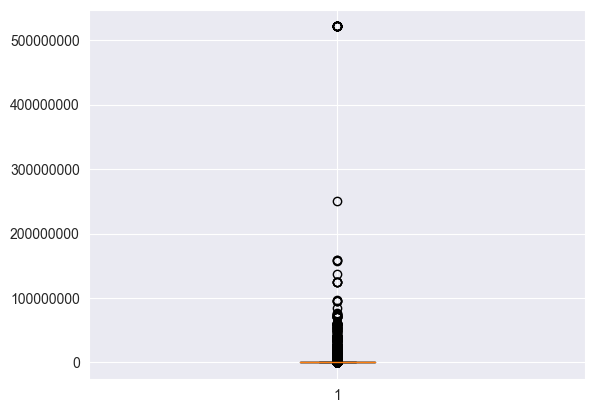

count     3369067.00
mean        20566.47
std       1210926.06
min             1.00
25%           311.00
50%          1747.00
75%          9685.00
max     521277800.00
Name: SHIPMT_VALUE, dtype: float64
----------------------
SHIPMT_WGHT
----------------------


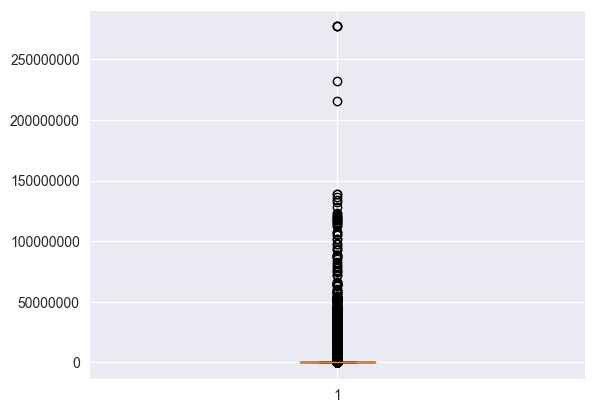

count     3369067.00
mean        38888.68
std        911307.81
min             1.00
25%           127.00
50%          1256.00
75%         22039.00
max     277029600.00
Name: SHIPMT_WGHT, dtype: float64
----------------------
SHIPMT_DIST_ROUTED
----------------------


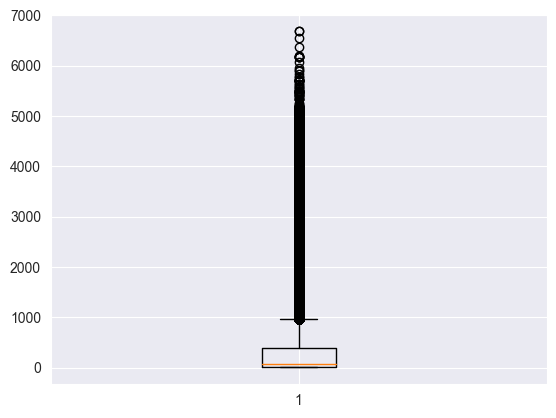

count   3369067.00
mean        333.76
std         562.73
min           1.00
25%          15.00
50%          68.00
75%         397.00
max        6677.00
Name: SHIPMT_DIST_ROUTED, dtype: float64
----------------------
GOOD_CATEGORY
----------------------


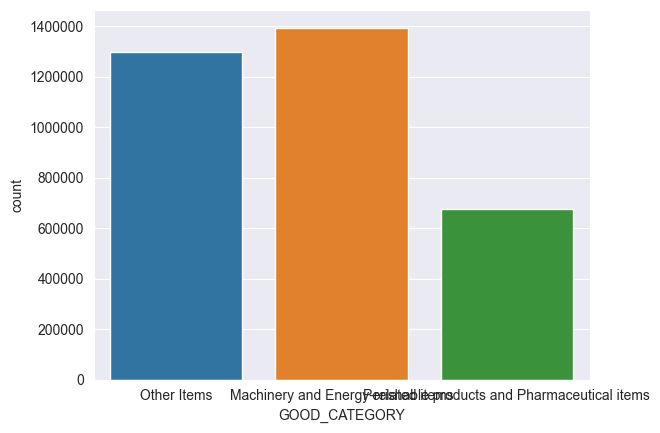

count                                3369067
unique                                     3
top       Machinery and Energy-related items
freq                                 1394647
Name: GOOD_CATEGORY, dtype: object


In [15]:
import matplotlib.pyplot as plt
import seaborn as sns

stratify_by = df_full[['SHIPMT_VALUE', 'SHIPMT_WGHT', 'SHIPMT_DIST_ROUTED', 'GOOD_CATEGORY']].copy()

def visualise(df):
  for i in df.columns:
    pd.set_option('float_format', '{:.2f}'.format)
    print("----------------------")
    print(i)
    print("----------------------")
    if df[i].dtype == "float64" or df[i].dtype == "int64":
      fig, ax = plt.subplots()
      ax.boxplot(df[i])
      ax.ticklabel_format(style='plain', axis='y')
      plt.show()
      print(df[i].describe())
    else:
      fig, ax = plt.subplots()
      sns.countplot(x=i, data=df, ax=ax)
      ax.ticklabel_format(style='plain', axis='y')
      plt.show()
      print(df[i].describe())

visualise(stratify_by)

In [16]:
from sklearn.model_selection import StratifiedShuffleSplit

num_bins = 5

for col in stratify_by.columns:
  if stratify_by[col].dtype == "float64" or stratify_by[col].dtype == "int64":
    # bin the continuous variable into `num_bins` bins
    stratify_by[col+"_bins"] = pd.cut(stratify_by[col], bins=num_bins, labels=False)
  else:
    stratify_by[col+"_bins"] = stratify_by[col]

# Then, perform stratified sampling on the new binned columns
split = StratifiedShuffleSplit(n_splits=1, test_size=0.99995, random_state=2410)

for train_index, test_index in split.split(stratify_by, stratify_by[col+"_bins"]):
    df = df_full.iloc[train_index].copy()
    test_df = df_full.iloc[test_index]

# Finally, drop the temporary binned columns
for col in stratify_by.columns:
    if "_bins" in col:
        stratify_by.drop(col, axis=1, inplace=True)

print(df.shape, test_df.shape)

(168, 10) (3368899, 10)


----------------------
SHIPMT_ID
----------------------


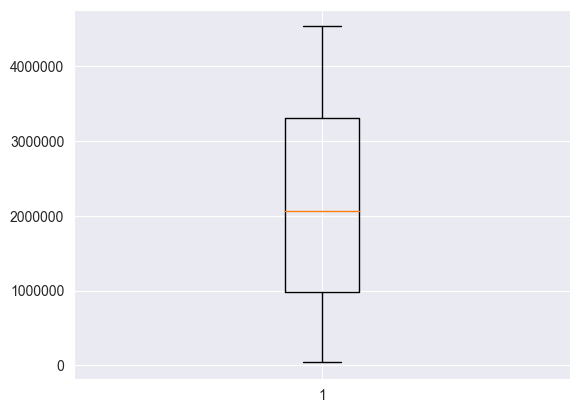

count       168.00
mean    2163293.70
std     1289758.53
min       38585.00
25%      976153.00
50%     2071550.50
75%     3311937.75
max     4535452.00
Name: SHIPMT_ID, dtype: float64
----------------------
ORIG_STATE
----------------------


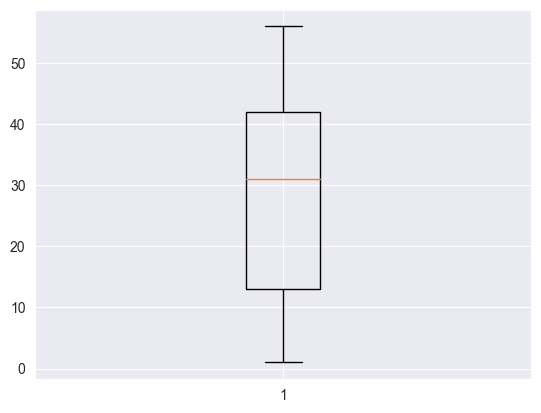

count   168.00
mean     28.88
std      15.79
min       1.00
25%      13.00
50%      31.00
75%      42.00
max      56.00
Name: ORIG_STATE, dtype: float64
----------------------
DEST_STATE
----------------------


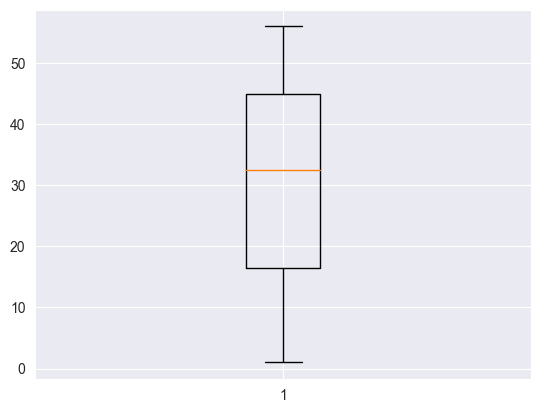

count   168.00
mean     29.96
std      16.27
min       1.00
25%      16.50
50%      32.50
75%      45.00
max      56.00
Name: DEST_STATE, dtype: float64
----------------------
QUARTER
----------------------


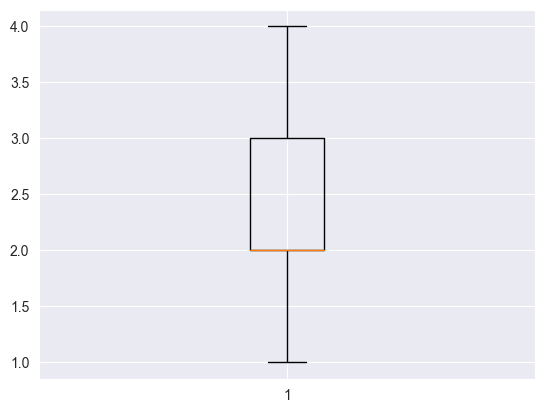

count   168.00
mean      2.46
std       1.05
min       1.00
25%       2.00
50%       2.00
75%       3.00
max       4.00
Name: QUARTER, dtype: float64
----------------------
MODE
----------------------


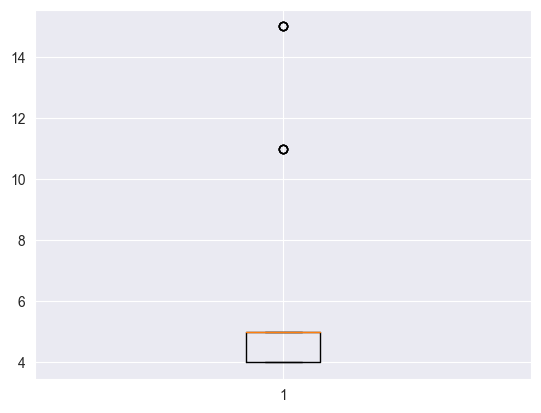

count   168.00
mean      4.93
std       1.93
min       4.00
25%       4.00
50%       5.00
75%       5.00
max      15.00
Name: MODE, dtype: float64
----------------------
SHIPMT_VALUE
----------------------


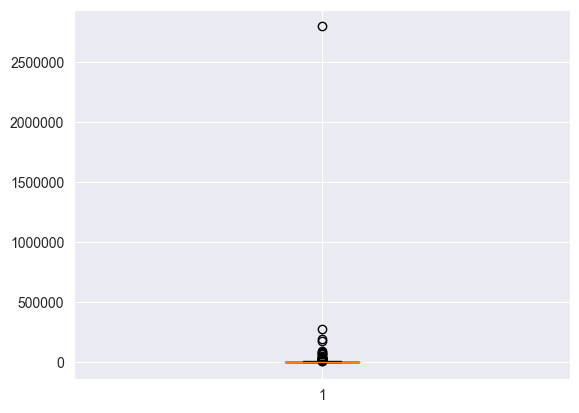

count       168.00
mean      27899.28
std      217058.71
min          11.00
25%         309.50
50%        1138.50
75%        6094.00
max     2792586.00
Name: SHIPMT_VALUE, dtype: float64
----------------------
SHIPMT_WGHT
----------------------


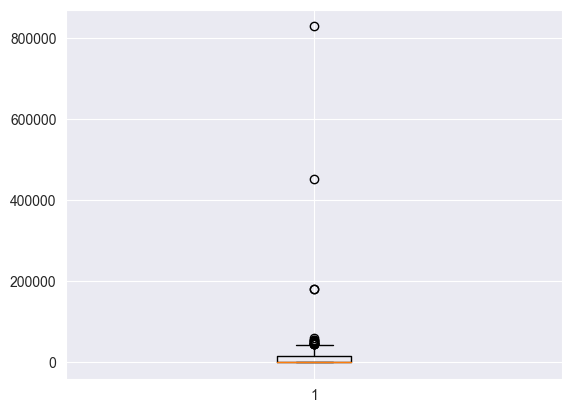

count      168.00
mean     19919.70
std      75475.28
min          1.00
25%        171.50
50%       1104.50
75%      17087.50
max     829010.00
Name: SHIPMT_WGHT, dtype: float64
----------------------
SHIPMT_DIST_ROUTED
----------------------


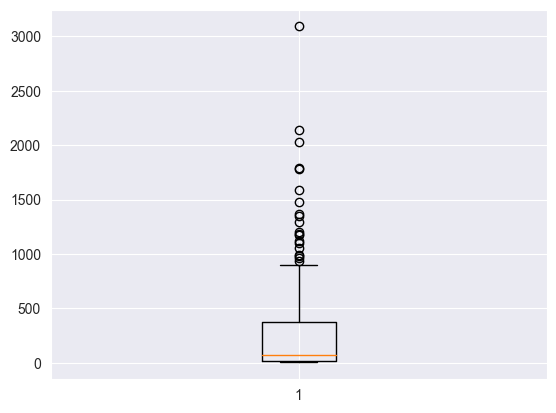

count    168.00
mean     303.23
std      498.55
min        2.00
25%       13.75
50%       67.50
75%      375.75
max     3092.00
Name: SHIPMT_DIST_ROUTED, dtype: float64
----------------------
TRANSPORT_MODE
----------------------


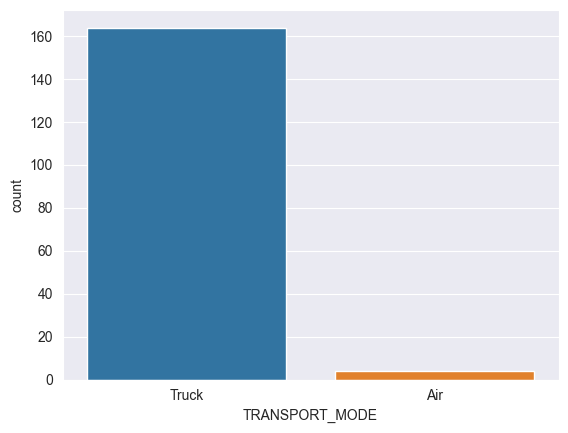

count       168
unique        2
top       Truck
freq        164
Name: TRANSPORT_MODE, dtype: object
----------------------
GOOD_CATEGORY
----------------------


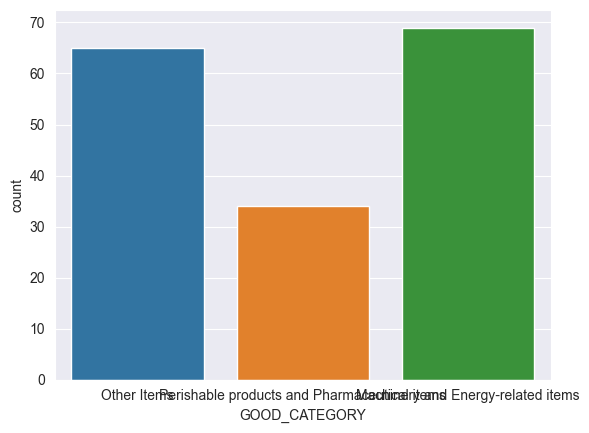

count                                    168
unique                                     3
top       Machinery and Energy-related items
freq                                      69
Name: GOOD_CATEGORY, dtype: object


In [17]:
visualise(df)

### OUR INPUT: Import the data we researched online

In [18]:
def math_round(num):
    if num % 1 >= 0.5:
        return int(num) + 1
    else:
        return int(num)

TOTAL_VEHICLES = 500
capacity = df_full.groupby('TRANSPORT_MODE').count()['SHIPMT_ID'].transform(lambda x: x /
    df_full.groupby('TRANSPORT_MODE').count()['SHIPMT_ID'].sum() * TOTAL_VEHICLES
)
capacity = capacity.reset_index()
capacity['SHIPMT_ID'] = capacity['SHIPMT_ID'].apply(lambda x: math_round(x))
capacity

MODE_CAPACITY_NUMBER = {
    TRANSPORT_MODE.TRUCK.value:     capacity.iloc[2,1],
    TRANSPORT_MODE.RAIL.value:      capacity.iloc[1,1],
    TRANSPORT_MODE.AIR.value:       capacity.iloc[0,1],
}
MODE_CAPACITY_NUMBER

{'Truck': 484, 'Rail': 6, 'Air': 10}

In [19]:
CATEGORY_LATE_BY = {
    SCTG_CATEGORIES.URGENT.value:   6,
    SCTG_CATEGORIES.PRIORITY.value: 10,
    SCTG_CATEGORIES.OTHERS.value:   14
}

In [20]:
MODE_COSTS = {
    TRANSPORT_MODE.TRUCK.value:     1.646*0.29125,
    TRANSPORT_MODE.RAIL.value:      0.048*10,
    TRANSPORT_MODE.AIR.value:       2.72,
}

MODE_CAPACITY_POUNDS = {
    TRANSPORT_MODE.TRUCK.value:     60000,
    TRANSPORT_MODE.RAIL.value:      190400,
    TRANSPORT_MODE.AIR.value:       300000,
}

In [21]:
MODE_TRAVEL_SPEED_PER_DAY = {
    TRANSPORT_MODE.TRUCK.value:     620,
    TRANSPORT_MODE.RAIL.value:      1860,
    TRANSPORT_MODE.AIR.value:       4000,
}

### Data preprocessing

#### Getting source and destination

In [22]:
reverse_index = {}

SRC_TO_DST = []

df = df.reset_index()

ID = -1
src_to_dst_mapper = {}
for idx, row in df.iterrows():
    src_to_dst = {'src': row['ORIG_STATE'], 'dst': row['DEST_STATE']}
    key = frozenset(src_to_dst.items())
    if key in src_to_dst_mapper:
        SRC_TO_DST.append(src_to_dst_mapper[key])
    else:
        ID += 1
        src_to_dst_mapper[key] = ID
        SRC_TO_DST.append(src_to_dst_mapper[key])
    if ID in reverse_index: 
      reverse_index[ID].append(idx)
    else:
      reverse_index[ID] = [idx]

df.loc[:, 'SRC_TO_DST'] = SRC_TO_DST

In [23]:
df.loc[:, 'Truck Cost'] = MODE_COSTS['Truck'] * df.loc[:, 'SHIPMT_DIST_ROUTED']
df.loc[:, 'Rail Cost'] = MODE_COSTS['Rail'] * df.loc[:, 'SHIPMT_DIST_ROUTED']
df.loc[:, 'Air Cost'] = MODE_COSTS['Air'] * df.loc[:, 'SHIPMT_WGHT']


# EXTRA LAYER
df.loc[:, 'Truck Duration'] = df.loc[:, 'SHIPMT_DIST_ROUTED'] / MODE_TRAVEL_SPEED_PER_DAY.get(TRANSPORT_MODE.TRUCK.value)
df.loc[:, 'Rail Duration'] = df.loc[:, 'SHIPMT_DIST_ROUTED'] / MODE_TRAVEL_SPEED_PER_DAY.get(TRANSPORT_MODE.RAIL.value)
df.loc[:, 'Air Duration'] = df.loc[:, 'SHIPMT_DIST_ROUTED'] / MODE_TRAVEL_SPEED_PER_DAY.get(TRANSPORT_MODE.AIR.value)

df

,index,SHIPMT_ID,ORIG_STATE,DEST_STATE,QUARTER,MODE,SHIPMT_VALUE,SHIPMT_WGHT,SHIPMT_DIST_ROUTED,TRANSPORT_MODE,GOOD_CATEGORY,SRC_TO_DST,Truck Cost,Rail Cost,Air Cost,Truck Duration,Rail Duration,Air Duration
0,125820,125821,50,33,3,5,20443,51660,133,Truck,Other Items,0,63.76,63.84,140515.20,0.21,0.07,0.03
1,849035,849036,21,17,1,4,31225,31225,484,Truck,Perishable products and Pharmaceutical items,1,232.03,232.32,84932.00,0.78,0.26,0.12
2,969786,969787,17,17,2,4,958,45915,81,Truck,Machinery and Energy-related items,2,38.83,38.88,124888.80,0.13,0.04,0.02
3,436831,436832,45,45,4,4,5274,12715,27,Truck,Other Items,3,12.94,12.96,34584.80,0.04,0.01,0.01
4,553517,553518,6,6,2,5,3371,603,134,Truck,Other Items,4,64.24,64.32,1640.16,0.22,0.07,0.03
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
163,1237715,1237716,29,29,3,5,5388,4671,196,Truck,Other Items,16,93.96,94.08,12705.12,0.32,0.11,0.05
164,3313544,3313545,21,18,4,4,14802,9866,7,Truck,Perishable products and Pharmaceutical items,95,3.36,3.36,26835.52,0.01,0.00,0.00
165,4199020,4199021,22,30,1,4,3747,1043,1788,Truck,Perishable products and Pharmaceutical items,96,857.16,858.24,2836.96,2.88,0.96,0.45
166,2798030,2798031,42,39,3,4,7481,641,546,Truck,Machinery and Energy-related items,97,261.75,262.08,1743.52,0.88,0.29,0.14


## Variables

In [24]:
S = df[['ORIG_STATE', 'DEST_STATE', 'GOOD_CATEGORY', 'SHIPMT_WGHT','SHIPMT_VALUE', 'SHIPMT_ID']].copy().values
S

array([[50, 33, 'Other Items', 51660, 20443, 125821],
       [21, 17, 'Perishable products and Pharmaceutical items', 31225,
        31225, 849036],
       [17, 17, 'Machinery and Energy-related items', 45915, 958, 969787],
       ...,
       [22, 30, 'Perishable products and Pharmaceutical items', 1043,
        3747, 4199021],
       [42, 39, 'Machinery and Energy-related items', 641, 7481, 2798031],
       [18, 13, 'Other Items', 1, 12, 653515]], dtype=object)

In [25]:
costs = df[['Truck Cost', 'Rail Cost', 'Air Cost']]
costs.columns =  TRANSPORT_MODE.TRUCK.value, TRANSPORT_MODE.RAIL.value, TRANSPORT_MODE.AIR.value
costs

,Truck,Rail,Air
0,63.76,63.84,140515.20
1,232.03,232.32,84932.00
2,38.83,38.88,124888.80
3,12.94,12.96,34584.80
4,64.24,64.32,1640.16
...,...,...,...
163,93.96,94.08,12705.12
164,3.36,3.36,26835.52
165,857.16,858.24,2836.96
166,261.75,262.08,1743.52


In [26]:
duration = df[['Truck Duration', 'Rail Duration', 'Air Duration']]
duration.columns = TRANSPORT_MODE.TRUCK.value, TRANSPORT_MODE.RAIL.value, TRANSPORT_MODE.AIR.value
duration

,Truck,Rail,Air
0,0.21,0.07,0.03
1,0.78,0.26,0.12
2,0.13,0.04,0.02
3,0.04,0.01,0.01
4,0.22,0.07,0.03
...,...,...,...
163,0.32,0.11,0.05
164,0.01,0.00,0.00
165,2.88,0.96,0.45
166,0.88,0.29,0.14


In [27]:
A = [
    MODE_CAPACITY_NUMBER.get(TRANSPORT_MODE.TRUCK.value),
    MODE_CAPACITY_NUMBER.get(TRANSPORT_MODE.RAIL.value),
    MODE_CAPACITY_NUMBER.get(TRANSPORT_MODE.AIR.value),
]
A

[484, 6, 10]

In [28]:
Pref = CATEGORY_LATE_BY
Pref

{'Perishable products and Pharmaceutical items': 6,
 'Machinery and Energy-related items': 10,
 'Other Items': 14}

In [29]:
cap = [
    MODE_CAPACITY_POUNDS.get(TRANSPORT_MODE.TRUCK.value),
    MODE_CAPACITY_POUNDS.get(TRANSPORT_MODE.RAIL.value),
    MODE_CAPACITY_POUNDS.get(TRANSPORT_MODE.AIR.value),
]
cap

[60000, 190400, 300000]

## Objective Value

In [30]:
def mode_mapper(mode):
    if mode == 0:
        return 'Truck'
    if mode == 1:
        return 'Rail'
    if mode == 2:
        return 'Air'
    return 'ERROR'

def pretty_print(X):
    res = {}

    for sid in range(X.shape[0]):
        id_found = False
        for mode in range(X.shape[1]):
            for _bin in range(X.shape[2]):
                if X[sid][mode][_bin] == 1 and id_found == False:
                    print(f"{sid}: Good {S[sid][-1]} shipped on day {_bin} using {mode_mapper(mode)}")
                    if _bin in res and mode_mapper(mode) in res[_bin]:
                        res[_bin][mode_mapper(mode)].append(S[sid][-1])
                    else:
                        res.setdefault(_bin, {})[mode_mapper(mode)] = [S[sid][-1]]
                    id_found = True
                elif X[sid][mode][_bin] == 1 and id_found == True:
                    print("ERROR ERROR ERROR: MORE THAN 1 SHIPMENT MADE FOR THIS GOOD")

    print(sorted(res.items()))

### BASE

In [31]:
model = ro.Model('BC2410 Project - Base')
NUM_ROWS = df.shape[0]
NUM_MODES = len(TRANSPORT_MODE.__members__)
NUM_DAYS = 99

# X looks like this
#    +--------+
#   /        /|
#  /        / |
# +--------+  | NUM_ROWS
# |        |  |
# |        |  +
# |        | /
# |        |/ NUM_DAYS
# +--------+
# TRUCK, RAIL, AR
X = model.dvar((NUM_ROWS, NUM_MODES, NUM_DAYS), 'B')
# for i in TRUCK, RAIL, AIR:
# id \ day 1 2 3 4 5
# 01
# 02
# 03

shipping_cost    = sum(X[row][mode][day]*costs.iloc[row,mode]
                       for row in range(NUM_ROWS) for mode in range(NUM_MODES) for day in range(NUM_DAYS))
shipping_penalty = sum(X[row][mode][day]*max(day+1-Pref.get(S[row][2]),0)*0.05*S[row][4]
                       for row in range(NUM_ROWS) for mode in range(NUM_MODES) for day in range(NUM_DAYS))
model.min(shipping_cost + shipping_penalty)


# each good must be transported by one and only one transport mode within the NUM_DAYS days
for row in range(NUM_ROWS):
  model.st(sum(X[row][mode][day] for mode in range(NUM_MODES) for day in range(NUM_DAYS)) == 1)


# weight cannot exceed maximum capacity
for mode in range(NUM_MODES):
    for day in range(NUM_DAYS):
        model.st(sum(X[row][mode][day]*S[row][3] for row in range(NUM_ROWS)) <= cap[mode]*A[mode])

model.solve(grb)
print(model.get())

Set parameter Username
Academic license - for non-commercial use only - expires 2024-04-01
Being solved by Gurobi...
Solution status: 2
Running time: 0.1460s
18337.332599999994


In [32]:
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
X.get()

array([[[1., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]],

       [[1., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]],

       [[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]],

       ...,

       [[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]],

       [[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]],

       [[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 1., 0., ..., 0., 0., 0.]]])

In [33]:
pretty_print(X.get())

0: Good 125821 shipped on day 0 using Truck
1: Good 849036 shipped on day 0 using Truck
2: Good 969787 shipped on day 9 using Truck
3: Good 436832 shipped on day 0 using Truck
4: Good 553518 shipped on day 0 using Truck
5: Good 125060 shipped on day 0 using Truck
6: Good 112596 shipped on day 0 using Truck
7: Good 4023275 shipped on day 0 using Truck
8: Good 2057996 shipped on day 0 using Truck
9: Good 1306301 shipped on day 0 using Truck
10: Good 2491696 shipped on day 0 using Truck
11: Good 3575755 shipped on day 9 using Truck
12: Good 2740770 shipped on day 0 using Truck
13: Good 1279214 shipped on day 0 using Air
14: Good 2996416 shipped on day 13 using Truck
15: Good 3727865 shipped on day 13 using Truck
16: Good 2962021 shipped on day 0 using Truck
17: Good 547723 shipped on day 0 using Truck
18: Good 3840863 shipped on day 12 using Truck
19: Good 2662882 shipped on day 0 using Truck
20: Good 573774 shipped on day 13 using Truck
21: Good 1839826 shipped on day 0 using Truck
22: G

### EXTRA I & II

In [34]:
model2 = ro.Model('BC2410 Project - Extra I')
X2 = model2.dvar((NUM_ROWS, NUM_MODES, NUM_DAYS), 'B')


# this is the binary decision variable, y, indicating if a source-destination pair is being travelled on at least once
NUM_SD = max(df['SRC_TO_DST'])+1
y = model2.dvar((NUM_SD, NUM_MODES, NUM_DAYS), 'B')


# EXTRA LAYER is the +duration
import math
shipping_cost    = sum(X2[row][mode][day]*costs.iloc[row,mode]
                       for row in range(NUM_ROWS) for mode in range(NUM_MODES) for day in range(NUM_DAYS))
shipping_penalty = sum(X2[row][mode][day]*max(math.ceil(day+1-Pref.get(S[row][2])+duration.iloc[row,mode]),0)*0.05*S[row][4]
                       for row in range(NUM_ROWS) for mode in range(NUM_MODES) for day in range(NUM_DAYS))
model2.min(shipping_cost + shipping_penalty)


# each good must be transported by one and only one transport mode within the NUM_DAYS days
for row in range(NUM_ROWS):
  model2.st(sum(X2[row][mode][day] for mode in range(NUM_MODES) for day in range(NUM_DAYS)) == 1)


# weight cannot exceed maximum capacity
for mode in range(NUM_MODES):
    for day in range(NUM_DAYS):
        model2.st(sum(X2[row][mode][day]*S[row][3] for row in range(NUM_ROWS)) <= cap[mode]*A[mode])


# the number of unique destinations to visit must be less than or equal to the number of transport we have
for mode in range(NUM_MODES):
  for day in range(NUM_DAYS):
    model2.st(sum(y[src_dst][mode][day] for src_dst in range(NUM_SD)) <= A[mode])

# this is to constrict y to make it dependent on X, another binary decision variable we have,
# to reflect that multiple goods can reach the same destination
"""
y is a matrix of binary variables
if y[src_to_dst][mode][day] == 1 => there is at least one shipment from src to dst being assigned to be shipped by s
"""
for mode in range(NUM_MODES):
  for day in range(NUM_DAYS):
    for src_to_dst, rows in reverse_index.items():
      model2.st(sum(X2[row][mode][day] for row in rows) <= y[src_to_dst][mode][day]*9999)

pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
model.solve(grb)
print(model2.get())

Being solved by Gurobi...
Solution status: 2
Running time: 0.1770s


RuntimeError: The model is unsolved or no solution is obtained.

In [ ]:
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
X2.get()

In [ ]:
pretty_print(X2.get())